In [59]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np

In [57]:
# add project folder path

import sys
sys.path.append('sprite-image-generation')

In [3]:
from diffusion_utilities import *
from model import *
from train import *
from denoise import *

In [4]:
# diffusion hyperparameters
timesteps = 500

# noise range
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image
save_dir = 'sprite-image-generation/c_weights/'

# training hyperparameters
batch_size = 100
n_epoch = 32
lrate=1e-3 # learning rate for neural network

In [5]:
# construct model
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

Construct DDPM noise schedule

In [6]:
# create set of noise values for each timestep
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1

# portion of original image left
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()

# no noise at starting point
ab_t[0] = 1

Load Dataset

In [7]:
# load dataset and construct optimizer
dataset = CustomDataset("sprite-image-generation/sprites_1788_16x16.npy", "sprite-image-generation/sprite_labels_nc_1788_16x16.npy", transform, null_context=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [ ]:
forward_diffusion(dataloader, nn_model, n_epoch, lrate, timesteps, save_dir, ab_t, device)

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31


Denoise with DDPM

In [8]:
# choose the model whose weight to use during denoising
model_number = 31

save_rate = 20

# number of noise elements we want to generate
n_sample = 32

Generate new images with the given context

Contexts can be randomly generated, user-defined and mixed.

In [9]:
def show_images(imgs, nrow=2):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
    plt.show()

**Randomly Generated Context**

Loaded in Context Model


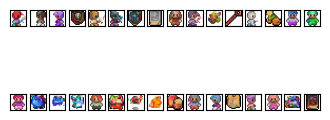

In [60]:
random_context = F.one_hot(torch.randint(0, 5, (32,)), 5).to(device=device).float()

samples, _ = DDPM_reverse_diffusion(n_sample, height, random_context, save_rate, device, timesteps, nn_model, model_number, save_dir, b_t, a_t, ab_t)

show_images(samples)

User Defined Context

5 categories were used in this project. Each column in the context refers to each category.
Categories: hero, non-hero, food, spell, side-facing

In the context defined here, we have 2 images for each of these categories except spell.

Loaded in Context Model


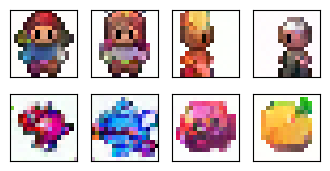

In [55]:
user_context = torch.tensor([
    [1,0,0,0,0],  # human
    [1,0,0,0,0],
    [0,0,0,0,1],  # side-facing
    [0,0,0,0,1],
    [0,1,0,0,0],  # non-hero
    [0,1,0,0,0],
    [0,0,1,0,0],  # food
    [0,0,1,0,0],
]).float().to(device)

samples, _ = DDPM_reverse_diffusion(user_context.shape[0], height, user_context, save_rate, device, timesteps, nn_model, model_number, save_dir, b_t, a_t, ab_t)

show_images(samples)

**Observation**:

In this picture, the first two pictures belong to human category. In these pictures, human like features are clearly observed. By default, images in this category are front-facing.

The third and fourth images include a person and an animal, both looking sideways - in this case, towards each other.

The fifth and sixth images represent non-hero characters. Here, these characters have non-human features.

The fifth and sixth images represent food. For example, the sixth image appears to be an image of a mango.

**Mixed Context**

The context values can be modified to achieve a combined image.

Loaded in Context Model


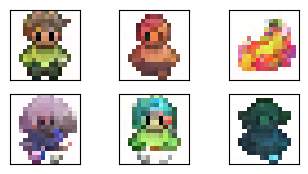

In [50]:
mixed_context = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],      # human
    [1,0,0.72,0,0],   # human, food
    [0,0.1,1,0,0],    # non-hero, food
    [1,0,0,0,1],      # human, side-facing
    [1,1,0,0,0],      # human, non-hero
    [1,0,0.3,0.7,0]   # human, food, spell
]).float().to(device)

samples, _ = DDPM_reverse_diffusion(mixed_context.shape[0], height, mixed_context, save_rate, device, timesteps, nn_model, model_number, save_dir, b_t, a_t, ab_t)

show_images(samples)

**Observation**:

In this picture, the first picture can be clearly identified as a human. But the second picture is a combination of human and food. Thus, the human shape is not quite clear.

The third image looks like an image of banana but due to the presence of non-hero element, the final output is blurred.

The fourth image is a combination of front-facing and side-facing human. Thus, no clear shape can be observed.

The fifth image is a combination of hero and non-hero. A clear human like shape is thus observed.

The last image is a combination of human, food and spell. Since the human category has higher value in the context, a clear outline of a human is observed. However, due to the presence of other categories, the final output is has food like appearance.